
# 主題：新聞文本NLP處理與真假新聞分類
#### 第十三組 第三次讀書會專案
組員：
N124020001 林坤郁
N124020004 陳忠泰
N124020005 陳莘惠
N124020006 張祐倫
N124020012 郭展州

<h2>一、資料簡介與目標</h2>
<h3>1.1資料簡介</h3>
資料來源Kaggle:https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?select=Fake.csv

本專案使用的資料集為 Fake and Real News Dataset，由 Kaggle 提供，原始資料包含兩個檔案：
<ol>
<li>Fake.csv：包含假新聞（Fake News）之標題與內文</li>
<li>True.csv：包含真新聞（Real News）之標題與內文</li>
</ol>
每筆資料具有以下欄位：
<ol>
<li>title：新聞標題</li>
<li>text：新聞文字內容</li>
<li>subject：主題類別，如政治、世界新聞等</li>
<li>date：新聞發布時間</li>
</ol>

在資料前處理階段，我們將兩份資料加上標籤（label），其中：
假新聞（Fake）標記為 0;真新聞（True）標記為 1
並合併成一份可供分類任務使用的整合資料集。

<h3>1.2目標</h3>
本次專案主要任務為：
<ol>
<li>觀察資料特別與分布</li>
<li>利用新聞文本內容來辨識新聞真偽（即真假新聞分類任務）
這是一個典型的二元分類問題（Binary Classification），我們將嘗試透過不同的文本表示方式（Text Embedding），來建立分類模型，判斷一篇新聞是「真」還是「假」</li>
<li>萃取多層次語言特徵： <ul> <li>語意層面：BERTopic 分析新聞主題</li> <li>結構層面：NER 實體數量作為特徵</li> <li>語氣層面：BERT 情緒分析</li> <li>詞彙層面：TF-IDF 擷取關鍵語詞</li> </ul></li>
<li>建構分類模型並分析結果：使用 Logistic Regression、RandomForest 並融合特徵訓練模型</li>
<li>主題分析與風險識別：BERTopic + 假新聞比例分析出高風險主題</li>
</ol>

<h3>二、引用套件與資料處理</h3>

<h4>2.1載入套件</h4>

In [2]:
import pandas as pd
import jieba
import jieba.analyse
import re
import numpy as np
from collections import defaultdict
import multiprocessing

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util, models

import seaborn as sns
import torch

from matplotlib.font_manager import fontManager
import plotly.express as px
from nltk.corpus import stopwords
import nltk
nltk.download('punkt','stopwords')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize


sns.set_style("darkgrid")

[nltk_data] Downloading package punkt to stopwords...
[nltk_data]   Package punkt is already up-to-date!


<h4>2.2資料處理</h4>

In [3]:
#讀檔
trueNews = pd.read_csv('./raw_data/true.csv')
fakeNews = pd.read_csv('./raw_data/fake.csv')
#新增新聞類別欄位
trueNews["label"] = 1
fakeNews["label"] = 0
#合併兩份檔案
df = pd.concat([trueNews,fakeNews],axis = 0 ).reset_index(drop=True)
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


把文章的title+text合併成為content欄位，做後續探索

In [4]:
df["content"] = df["title"].astype(str) + " : " + df["text"].astype(str)
df.head()


,title,text,subject,date,label,content
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...


移除移除標點符號、數字、小寫化等基本清理

In [5]:
def clean_text(text):
    text = text.lower()                          # 小寫化
    text = re.sub(r'\d+', '', text)              # 移除數字
    text = re.sub(r'[^\w\s]', '', text)          # 移除標點符號
    text = re.sub(r'\s+', ' ', text).strip()     # 移除多餘空白
    return text

df["content_clean"] = df["content"].apply(clean_text)


使用 NLTK 進行英文斷詞（tokenization）

In [6]:
df["tokens"] = df["content_clean"].apply(word_tokenize)


去除停用詞（stopwords）與詞幹還原（stemming）

In [7]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def preprocess_tokens(tokens):
    return [
        stemmer.stem(word) 
        for word in tokens 
        if word not in stop_words and len(word) > 1
    ]

df["tokens_clean"] = df["tokens"].apply(preprocess_tokens)


<h2>三、word2vec</h2>


<h3>3.1依照資料訓練自己的模型</h3>

In [8]:
# 用tokens_clean 當input
sentences = df["tokens_clean"].tolist()

# 建bigram模型
bigram = Phrases(sentences, min_count=1, threshold=2)
bigram_phraser = Phraser(bigram)

# 用bigram 模型，把threshold以上的詞合併
df["tokens_bigram"] = df["tokens_clean"].apply(lambda x: bigram_phraser[x])

In [9]:
# 查看機器的core
cores = multiprocessing.cpu_count()
print(f"number of cores: {cores}")

number of cores: 12


In [10]:
# 只保tokens_bigram欄位的資料
sentences = df["tokens_bigram"].tolist()

# 8:2切資料
sentences_train, sentences_test = train_test_split(sentences, test_size=0.2, random_state=42)

# 訓練 Word2Vec 模型
w2v_model = Word2Vec(
    sentences = sentences_train,    # 使用訓練語料
    vector_size = 128,              # vector 的維度
    alpha = 0.0005, #learning rate
    window = 2,                    # 上下文視窗大小
    min_count = 30,                  # 忽略出現次數少於30次的詞
    workers= cores-2,                  # CPU core
    sg = 1,                         # 1 = skip-gram, 0 = CBOW
    epochs = 30,
    hs = 1,
    seed = 8888
)

# 訓練模型
w2v_model.train(sentences_train, total_examples=len(sentences_train), epochs=10)

# 儲存模型
w2v_model.save("w2v_fake_news.model")

查看結果

In [11]:
# 檢查最相關的字 (cosine similarity)
w2v_model.wv.most_similar('trump',topn=10)

[('presid_trump', 0.7452251315116882),
 ('trump_campaign', 0.690837025642395),
 ('trump_administr', 0.6554872393608093),
 ('mr_trump', 0.640625),
 ('penc', 0.6327669620513916),
 ('trump_tweet', 0.6320326328277588),
 ('republican_presidenti', 0.6220606565475464),
 ('cruz', 0.6214054226875305),
 ('donald', 0.6157160401344299),
 ('trump_repeatedli', 0.6138792037963867)]

In [12]:
w2v_model.wv.most_similar('trump','biden',topn=10)

[('donald_trump', 0.26707953214645386),
 ('trump_campaign', 0.22942546010017395),
 ('trump_administr', 0.18937209248542786),
 ('presid_trump', 0.15339605510234833),
 ('presid_donald', 0.12167797237634659),
 ('republican_presidenti', 0.11736207455396652),
 ('wall', 0.11728308349847794),
 ('us_border', 0.11067304015159607),
 ('russia', 0.10440565645694733),
 ('north_korea', 0.09612814337015152)]

跟兩個字最不相關

In [13]:
w2v_model.wv.most_similar(negative=['trump','biden'],topn=10)

[('page_get', -0.04473259672522545),
 ('feder', -0.04594121873378754),
 ('js_dcreateel', -0.059184152632951736),
 ('jsid_id', -0.060665976256132126),
 ('boiler_room', -0.06297771632671356),
 ('share_program', -0.06615214794874191),
 ('fj_dgetelementsbytagnam', -0.06757236272096634),
 ('dgetelementbyidid_return', -0.06813310086727142),
 ('liberti_union', -0.068699412047863),
 ('visit_donat', -0.06979236751794815)]

In [14]:
# 計算兩個字之間的關係
w2v_model.wv.similarity("china","america")

0.34489363

In [15]:
w2v_model.wv.similarity("china","taiwan")

0.8097163

In [16]:
# 取得所有的字
words = w2v_model.wv.key_to_index.keys()

In [17]:
# 降維：利用PCA tSNE

def reduceDim(mat,method:str='PCA',dim:str=2,perplexity = 25,learning_rate = 400):

    method_dict = {
        "PCA":PCA(n_components=dim,iterated_power = 1000,random_state=0),
        "TSNE":TSNE(n_components=dim,random_state=0,perplexity=perplexity,learning_rate=learning_rate),
    }
    new_feat = method_dict[method].fit_transform(mat)

    return new_feat

In [18]:
# 拿到list of words 的vector
def getVecs(model,words:list):
    vecs = []
    for i in words:
        vecs.append(model.wv[i])
    return np.vstack(vecs)

In [19]:
getVecs(w2v_model,['taiwan','china'])

array([[-0.32659963, -0.1845669 ,  0.23963271, -0.4986037 ,  0.08959665,
         0.00331891, -0.19728707, -0.12914431,  0.27276677, -0.18598433,
        -0.06534845, -0.05050773, -0.22998892, -0.13254724, -0.1563083 ,
        -0.359723  , -0.11314997,  0.10440577, -0.42660767, -0.04534464,
         0.26782116, -0.3993701 ,  0.00142297, -0.10487995,  0.42597088,
         0.21871509, -0.47592917, -0.2995063 ,  0.15996924, -0.0798673 ,
        -0.13316265,  0.03984607, -0.27695447,  0.19720909,  0.36903617,
        -0.01410864,  0.38143653, -0.10456708,  0.10041433,  0.12507564,
         0.01848849, -0.08360445, -0.23580942, -0.14303674, -0.17703226,
        -0.11567995,  0.24558467,  0.15682843,  0.11964081, -0.677225  ,
         0.10065701,  0.13868238, -0.15315638,  0.01121648, -0.18889768,
        -0.12245064,  0.21219882,  0.32252544, -0.04312328, -0.1479061 ,
        -0.02277194,  0.1153541 , -0.27952856,  0.2573058 , -0.13251787,
         0.01758051, -0.04312113,  0.05957367, -0.1

In [20]:
# 擴展相似的字詞
def expandPosWord(model, words:list, top_n:int, split = True):

    if split == False:
        wp = model.wv.most_similar(words,topn = top_n)
        return wp
    expand = []

    for w in words:
        wp = model.wv.most_similar(w,topn = top_n)
        for i in wp:
            expand.append(i[0])

    return list(set(expand))

In [21]:
expandPosWord(w2v_model,['china','taiwan'],top_n = 10)

['south_korea',
 'tension',
 'xi',
 'intern_commun',
 'pyongyang',
 'korean_peninsula',
 'two_countri',
 'vietnam',
 'venezuela',
 'diplomat_said',
 'india',
 'taiwan',
 'beij',
 'us_alli',
 'japan']

In [22]:
# 畫出兩維的散佈圖
def plotScatter(vec_df):
    """
    vec_df: 字詞及其兩個維度的值
    """
    plt.figure(figsize=(15,15))
    fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.rcParams['font.size'] = '16'

    p = sns.scatterplot(x="dim1", y="dim2",
                  data=vec_df)
    for line in range(0, vec_df.shape[0]):
         p.text(vec_df["dim1"][line],
                 vec_df['dim2'][line],
                 '  ' + vec_df["word"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 weight='normal'
                ).set_size(15)
    plt.show()

# 畫出三維的散佈圖
def plotScatter3D(vec_df):
    vec_df['size'] = .5
    if 'color' not in vec_df.columns:
        vec_df['color'] = 'blue'
    fig = px.scatter_3d(
        vec_df,'dim1','dim2','dim3',text = 'word',width=800, height=800,color = 'color',size = 'size'

    )

    fig.show()

In [23]:
sample_words = np.random.choice(list(words),150,replace=False).tolist()

feat = getVecs(model=w2v_model,words=sample_words)
print(feat.shape)
new_feat = reduceDim(feat,method='TSNE',perplexity=20,learning_rate = 800)
print(new_feat.shape)

(150, 128)
(150, 2)


In [24]:
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
})

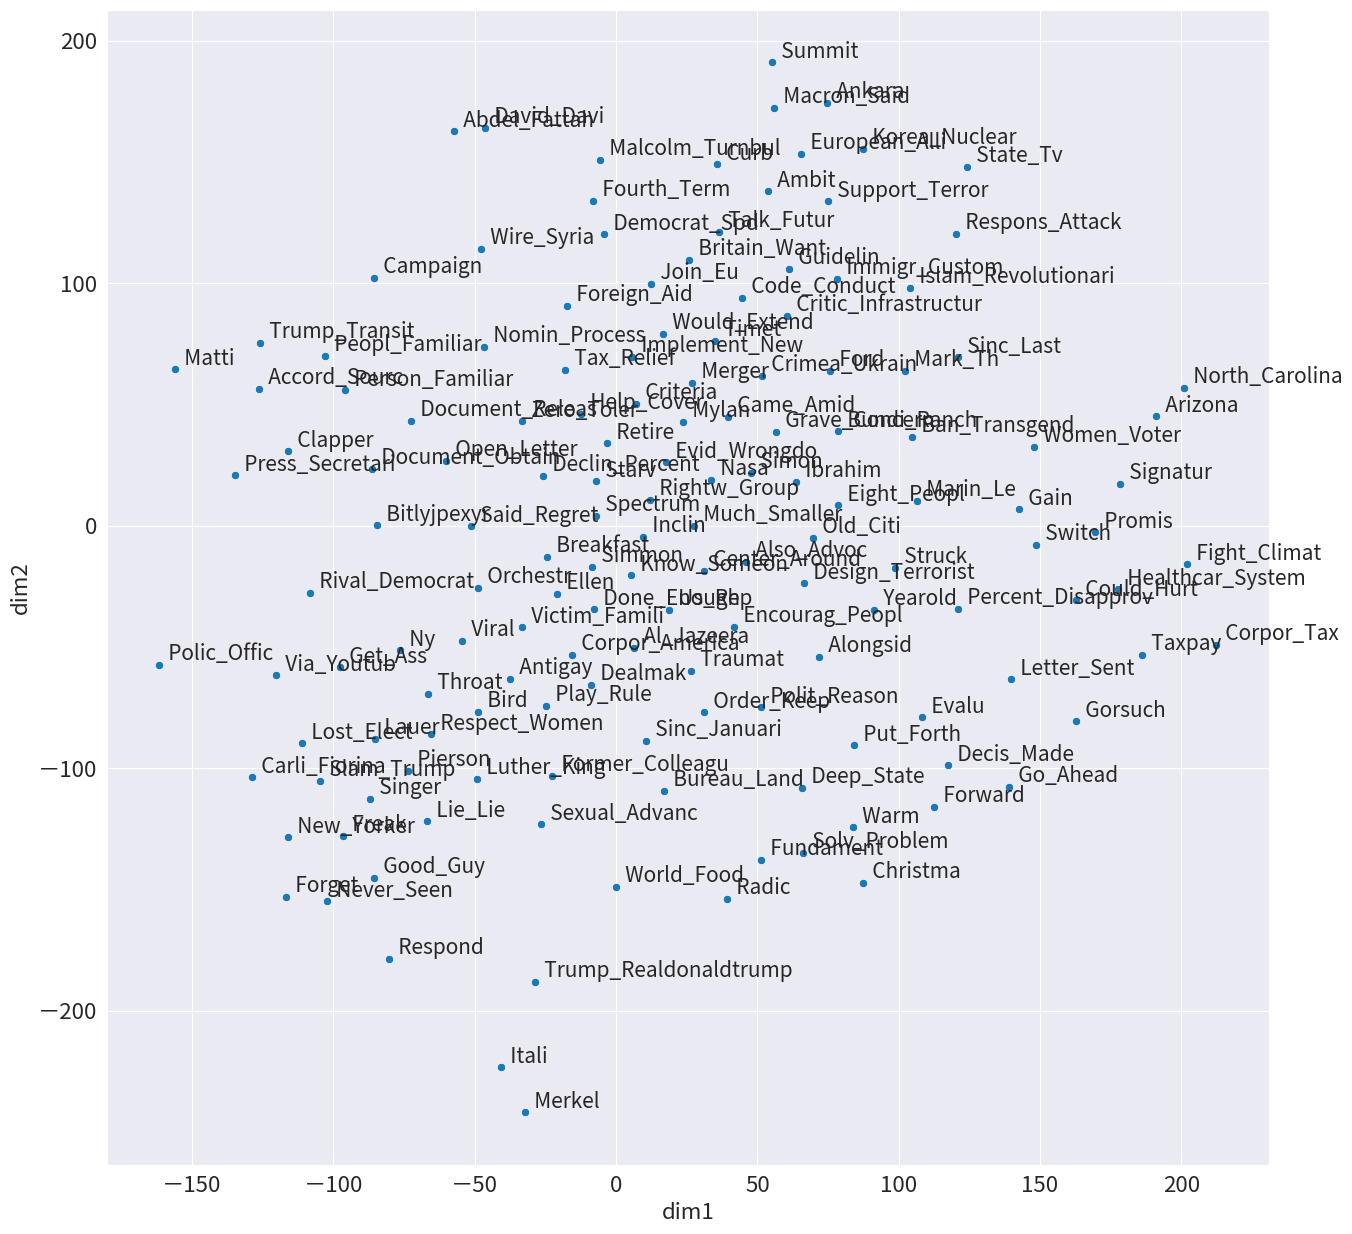

In [25]:
plotScatter(word_df)

3D 散狀圖

In [26]:
new_feat = reduceDim(feat,dim = 3,method = 'PCA' )
print(new_feat.shape)
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
    "dim3":new_feat[:,2],
})
plotScatter3D(word_df)

(150, 3)


將字分群

In [27]:
#!pip install scikit-learn-extra

In [28]:
#只使用word vector 去分群
def cluster(X,method = 'kmeans',n = 2):

    method_dict = {
        'kmeans':KMeans(n_clusters=n, random_state=0),
        'kmedos':KMedoids(n_clusters=n, random_state=0)
    }
    method_dict[method].fit(X)
    result = method_dict[method].predict(X)
    return result

In [29]:
new_feat = reduceDim(feat,method='PCA',dim = 20)
d3_feat = reduceDim(feat,method='PCA',dim = 3)
word_df = pd.DataFrame({
    "word":sample_words,
    "color":cluster(new_feat,n=4),
    "dim1":d3_feat[:,0],
    "dim2":d3_feat[:,1],
    "dim3":d3_feat[:,2],

})
plotScatter3D(word_df)

<h3>3.2 Transformers Embeddings</h3>

In [30]:
#!pip install -U sentence-transformers

<h4>小模型，以BERT為範例</h4>

In [31]:
# 英文 bert-base-uncased
bert_en = SentenceTransformer('google-bert/bert-base-uncased')

bert_en.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

No sentence-transformers model found with name google-bert/bert-base-uncased. Creating a new one with mean pooling.


0

In [32]:
bert_en.get_max_seq_length()

512

In [33]:
# 回傳cosine similarity分數
def get_result_df(sentences, cosine_scores):

  result = []
  for i in range(len(sentences)):
      for j in range(i+1, len(sentences)):
          result.append([sentences[i], sentences[j], cosine_scores[i][j].item()])

  result_df = pd.DataFrame(result, columns=["sentence1", "sentence2", "score"])
  result_df = result_df.sort_values("score", ascending = False)

  return result_df

In [34]:
# 多語言 bert-base-multilingual-cased
bert_multi = SentenceTransformer('google-bert/bert-base-multilingual-cased')

bert_multi.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

No sentence-transformers model found with name google-bert/bert-base-multilingual-cased. Creating a new one with mean pooling.


0

In [35]:
# 示範句子
sentences = [
    "Trump's treatening the world under the tariff policy.",
    "The quick brown fox jumps over the lazy dog.",
    "川普正在藉由關稅政策威脅世界。"
]

# 使用 encode() 對資料做embedding
embeddings_multi = bert_multi.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_multi, embeddings_multi)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

,sentence1,sentence2,score
1,Trump's treatening the world under the tariff ...,川普正在藉由關稅政策威脅世界。,0.564212
2,The quick brown fox jumps over the lazy dog.,川普正在藉由關稅政策威脅世界。,0.366150
0,Trump's treatening the world under the tariff ...,The quick brown fox jumps over the lazy dog.,0.362455


<h3>四、使用embedding做NLP任務</h3>

<h4>4.1相似文件</h4>

In [36]:
# 使用英文預訓練 BERT 模型（適合英文句子）
model = SentenceTransformer('all-MiniLM-L6-v2')

# 將所有新聞內容轉換為向量
corpus_embeddings = model.encode(df['content'].tolist(), convert_to_tensor=True, batch_size=32)

# 任選一篇新聞作為查詢對象（你可自行更換 query_num 數值）
query_num = 10
query_embedding = model.encode(df['content'][query_num], convert_to_tensor=True)

# 計算與其他新聞的 cosine similarity
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]

# 取相似度前五高的文章
top_k = 5
top_results = torch.topk(cos_scores, k=top_k)

# 顯示結果
print("\n\n======================")
print("查詢新聞標題:\n", df['title'][query_num])
print("\n最相似的新聞:")

for score, idx in zip(top_results[0], top_results[1]):
    print(f"{df['title'][idx.item()]} (Score: {score:.4f})")

print("======================\n\n")




查詢新聞標題:
 Jones certified U.S. Senate winner despite Moore challenge

最相似的新聞:
Jones certified U.S. Senate winner despite Moore challenge (Score: 1.0000)
Alabama to certify Democrat Jones winner of Senate election (Score: 0.9049)
Trump urges Moore to concede Alabama Senate race (Score: 0.9037)
Alabama Senate race winner urges Republican rival to 'move on' (Score: 0.8801)
Democrat wins U.S. Senate seat in Alabama in setback for Trump (Score: 0.8756)




<h4>4.2分類任務</h4>

轉成向量（用 title+text 合併的 content 欄位）

In [37]:
corpus = df["content"].tolist()
embeddings = model.encode(corpus, batch_size=32, show_progress_bar=True)

Batches:   0%|          | 0/1404 [00:00<?, ?it/s]

建立分類器（以 sklearn的邏輯回歸 ）

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(embeddings, df["label"], test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.95      0.95      4650
           1       0.95      0.95      0.95      4330

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



包成function

In [ ]:
def predict_news_authenticity(title: str, content: str, model_embed, clf):
    """
    輸入新聞標題與內文，使用已訓練的嵌入模型與分類器預測真假。
    
    參數：
    - title: 新聞標題（字串）
    - content: 新聞內文（字串）
    - model_embed: SentenceTransformer 模型
    - clf: 訓練好的分類模型（如 LogisticRegression）

    輸出：
    - 預測結果（True/Fake）
    - True 機率
    - Fake 機率
    """
    full_text = f"{title.strip()} : {content.strip()}"
    embedding = model_embed.encode(full_text).reshape(1, -1)
    pred_label = clf.predict(embedding)[0]
    pred_prob = clf.predict_proba(embedding)[0]

    result = "True" if pred_label == 1 else "Fake"
    true_prob = round(pred_prob[1], 4)
    fake_prob = round(pred_prob[0], 4)

    print(f"預測結果：{result}")
    print(f"True 機率：{true_prob}")
    print(f"Fake 機率：{fake_prob}")
    
    return result, true_prob, fake_prob


In [ ]:
test_title = 
content =